In [1]:
from keras.models import load_model, model_from_json
from keras.models import Sequential, Model
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Reshape, Activation, Conv2D, Input, MaxPooling2D, BatchNormalization, Flatten, Dense, Lambda, GlobalAveragePooling2D, Dropout
from keras.layers.advanced_activations import LeakyReLU
from keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard
from keras.optimizers import SGD, Adam, RMSprop
from keras.layers.merge import concatenate
from skimage.io import imread
from skimage.transform import resize
import numpy as np
import keras.backend as K
import pickle
import cv2
import matplotlib.pyplot as plt
import matplotlib.patches as patches
%matplotlib inline

Using TensorFlow backend.


In [2]:
# loading weights after finetuning

vgg = load_model('./train_dataset_weights/VGG/VGG-finetuned_last3-67-0.86.hdf5')

In [2]:
resnet = load_model('./train_dataset_weights/resnet/resnet-finetuned_last3-50-0.90.hdf5')

In [3]:
test_img = imread('./classification_dataset/dog/2009_000156.jpg')
test_img = resize(test_img, (224, 224, 3), mode='reflect')

In [2]:
train_data_dir = './classification_dataset/'
validation_data_dir = './classification_val/'
batch_size = 32
train_datagen = ImageDataGenerator(
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True)
test_datagen = ImageDataGenerator(rescale=1. / 255)

train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='categorical')

validation_generator = test_datagen.flow_from_directory(
    validation_data_dir,
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='categorical')

Found 8751 images belonging to 19 classes.
Found 330 images belonging to 19 classes.


In [4]:
class_indices = train_generator.class_indices

In [5]:
class_indices

{'aeroplane': 0,
 'bicycle': 1,
 'bird': 2,
 'boat': 3,
 'bottle': 4,
 'bus': 5,
 'car': 6,
 'cat': 7,
 'chair': 8,
 'cow': 9,
 'dog': 10,
 'horse': 11,
 'motorbike': 12,
 'person': 13,
 'pottedplant': 14,
 'sheep': 15,
 'sofa': 16,
 'train': 17,
 'tvmonitor': 18}

In [6]:
with open('class_indices.pkl', 'wb') as towrite:
    pickle.dump(train_generator.class_indices, towrite)

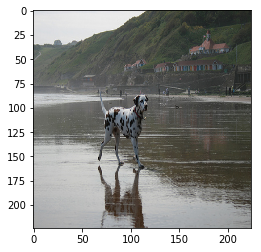

In [4]:
plt.imshow(test_img)

In [9]:
preds = vgg.predict(np.expand_dims(test_img, 0))

In [5]:
preds = resnet.predict(np.expand_dims(test_img, 0))

In [14]:
preds

array([[  8.76540823e-25,   3.98630936e-30,   2.17474259e-12,
          4.39915020e-29,   5.59799045e-31,   0.00000000e+00,
          3.70518619e-24,   1.72996252e-07,   5.02905549e-34,
          2.51056147e-13,   9.99999881e-01,   6.24352132e-12,
          9.08781013e-26,   5.36333185e-13,   3.58825975e-31,
          5.01158097e-15,   1.79651995e-34,   1.03762191e-27,
          1.83958445e-36]], dtype=float32)

In [3]:
def interpret_preds(preds, class_indices=None, print_message=1):
    labels = np.zeros(preds.shape)
    labels[preds>0.5] = 1
    index = np.argmax(labels, axis=-1)
    if not print_message:
        return index[0]
    for each_class, val in class_indices.items():
        if val == index:
            return("predicted class : " + each_class , "predicted index : " + str(index[0]))

In [11]:
interpret_preds(preds, class_indices=class_indices, print_message=1)

('predicted class : dog', 'predicted index : 10')

In [4]:
def gradcam(model, img_path, layer_name):
    
    img = imread(img_path)
    input_shape = img.shape
    
    model_input_shape = model.input_shape[1:]
    
    if img.shape != model_input_shape:
        x = resize(img, model_input_shape, mode='reflect')
    
    if len(input_shape) != 4:
        x = np.expand_dims(x, 0)
        
    preds = model.predict(x)
    
    class_index = interpret_preds(preds, print_message=0)
    
    #print(class_index)
    
    # get class output
    class_output = model.output[:, class_index]

    # get the required conv layer
    conv_layer = model.get_layer(layer_name)
    num_channels = conv_layer.output_shape[-1]
    
    # This is the gradient of the predicted class with respect to
    # the requested feature map
    grads = K.gradients(class_output, conv_layer.output)[0]

    # vector of mean intensities of the gradient over a specific feature map channel
    # ie its len would be equal to number of channels in the conv layer
    mean_grads = K.mean(grads, axis=(0, 1, 2))

    # function to access the values of mean_grads and the output feature map
    get_values = K.function([model.input, K.learning_phase()], [mean_grads, conv_layer.output[0]])


    mean_grads_value, conv_layer_output_value = get_values([x, 0])

    # multiply each channel in the feature map array by each channel with respect to the output class
    for i in range(num_channels):
        conv_layer_output_value[:, :, i] *= mean_grads_value[i]

    # The channel-wise mean of the resulting feature map results in heatmap
    heatmap = np.mean(conv_layer_output_value, axis=-1)
    
    heatmap = np.maximum(heatmap, 0)
    heatmap /= np.max(heatmap)
    #plt.matshow(heatmap)
    #plt.show()
    
    
    heatmap = cv2.resize(heatmap, (input_shape[1], input_shape[0]))

    # convert the heatmap to RGB
    heatmap = np.uint8(255 * heatmap)
    

    # apply the heatmap to the original image
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

    cv2.imwrite('./heatmap_' + layer_name + '.jpg', heatmap)
    
    # 0.4 here is a heatmap intensity factor
    superimposed_img = heatmap * 0.4 + img

    cv2.imwrite('./image_cam_' + layer_name + '.jpg', superimposed_img)

In [58]:
vgg.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

In [13]:
resnet.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 112, 112, 64) 9472        input_1[0][0]                    
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 112, 112, 64) 256         conv1[0][0]                      
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 112, 112, 64) 0           bn_conv1[0][0]                   
__________________________________________________________________________________________________
max_poolin

In [44]:
#imgpath = './classification_dataset/dog/2009_000181.jpg'
#imgpath = './classification_dataset/dog/2009_000156.jpg'
#imgpath = './classification_dataset/car/005706.jpg'
imgpath = './bbox_dataset/images/2007_008764.jpg'
layer_name = 'block5_conv3'
#layer_name = 'add_7'
#layer_name = 'add_13'
#layer_name = 'add_16'

In [45]:
gradcam(vgg, imgpath, layer_name)

In [5]:
def bbox_gcam(hmap_path, img_path, imgname, save_path):
    hmap = cv2.imread(hmap_path, 0)
    ret, thresh = cv2.threshold(hmap, 127,255,cv2.THRESH_BINARY)
    image, contours, hier = cv2.findContours(thresh, cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)
    bestbox = 0
    maxarea = 0
    for c in contours:
        bbox = cv2.boundingRect(c)
        area = bbox[2] * bbox[3]
        if maxarea < area:
            maxarea = area
            bestbox = bbox
    try:
        
        img = imread(img_path)
        plt.imshow(img)
        plt.gca().add_patch(plt.Rectangle((bestbox[0], bestbox[1]), bestbox[2],bestbox[3], fill=False, linewidth=2, color='g'))
        plt.savefig(save_path + imgname +'.jpg', bbox_inches='tight')
        plt.clf()
        return bestbox
    except:
        return 0

In [48]:
hmap_path = './heatmap_block5_conv3.jpg'
img_path = './image_cam_block5_conv3.jpg'
imgname = '2007_008764'
save_path = './bbox_pics/vgg/'
bbox_gcam(hmap_path, img_path, imgname, save_path)

(97, 34, 175, 169)

In [20]:
def fuse_maps(map1, map2, map3, save=False):
    
    im1, im2, im3 = imread(map1), imread(map2), imread(map3)
    result = im1 / 255 + im2 / 255 + im3 / 255
    result[result > 1] = 1
    if save:
        plt.imsave('fused_maps.jpg', result)
    else:
        plt.imshow(result)

In [41]:
def fuse_imgs(im1, im2, im3, save=False):
    im1, im2, im3 = imread(im1), imread(im2), imread(im3)
    result = im1 / 255 + im2 / 255 + im3 / 255
    result[result > 1] = 1
    if save:
        plt.imsave('fused_images.jpg', result)
    else:
        plt.imshow(result)

In [52]:
im1 = './heatmap_block5_conv3.jpg'
im2 = './heatmap_block4_conv3.jpg'
im3 = './heatmap_block5_conv1.jpg'

In [21]:
im1 = './heatmap_add_7.jpg'
im2 = './heatmap_add_13.jpg'
im3 = './heatmap_add_16.jpg'

In [42]:
img1 = './image_cam_block5_conv3.jpg'
img2 = './image_cam_block4_conv3.jpg'
img3 = './image_cam_block5_conv1.jpg'

In [22]:
fuse_maps(im1, im2, im3, save=True)

In [43]:
fuse_imgs(img1, img2, img3, save=True)

In [67]:
im1 = imread('./heatmap_block5_conv3.jpg')
im2 = imread('./heatmap_block5_conv2.jpg')
im3 = imread('./heatmap_block5_conv1.jpg')
im4 = imread('./heatmap_block4_conv3.jpg')

In [23]:
im1 = imread('./heatmap_add_13.jpg')
im2 = imread('./heatmap_add_16.jpg')
#im3 = imread('./heatmap_block5_conv1.jpg')
#im4 = imread('./heatmap_block4_conv3.jpg')

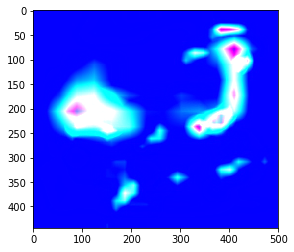

In [69]:
result2 = im1 / 255 +  im4/255 + im3/255 + im2/255
result2[result2 > 1] = 1
plt.imshow(result2)

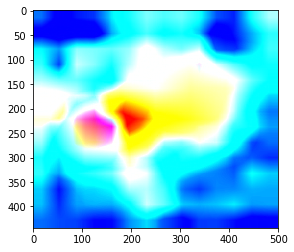

In [24]:
result2 = im1 / 255 +  im2 / 255
result2[result2 > 1] = 1
plt.imshow(result2)

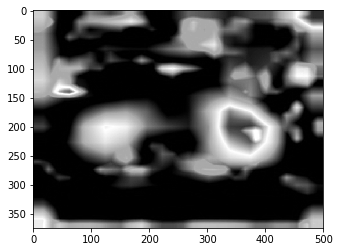

In [166]:
hmap = cv2.imread('./images_save/car/fused_maps.jpg', 0)
plt.imshow(hmap, cmap='gray')

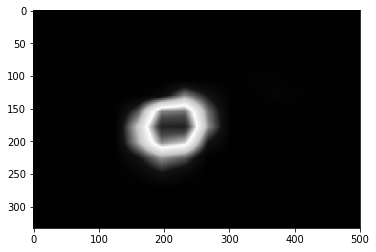

In [14]:
hmap = cv2.imread('./heatmap_block5_conv3.jpg', 0)
plt.imshow(hmap, cmap='gray')

In [15]:
ret, thresh = cv2.threshold(hmap, 127,255,cv2.THRESH_BINARY)

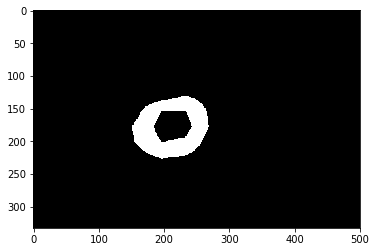

In [16]:
plt.imshow(thresh, cmap='gray')

In [17]:
image, contours, hier = cv2.findContours(thresh, cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)

In [18]:
bestbox = 0
maxarea = 0
for c in contours:
    bbox = cv2.boundingRect(c)
    area = bbox[2] * bbox[3]
    if maxarea < area:
        maxarea = area
        bestbox = bbox

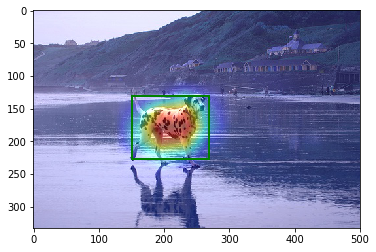

In [19]:
img = imread('./image_cam_block5_conv3.jpg')
plt.imshow(img)
x, y, w, h = bestbox
plt.gca().add_patch(plt.Rectangle((x, y), w,h, fill=False, linewidth=2, color='g'))
plt.show()

16265.5
22632
False
3700.0
5670
False


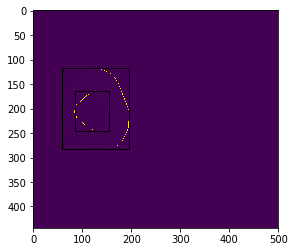

In [145]:
plt.imshow(thresh)
for c in contours:
    x, y, w, h = cv2.boundingRect(c)
    print(cv2.contourArea(c))
    print(w*h)
    print(cv2.isContourConvex(c))
    plt.gca().add_patch(plt.Rectangle((x, y), w,h, fill=False))
plt.show()

In [19]:
test_x, test_y = np.where(thresh == 0)

In [20]:
test_x, test_y

(array([126, 126, 126, ..., 234, 234, 235], dtype=int64),
 array([230, 231, 232, ..., 197, 198, 196], dtype=int64))

In [21]:
xmin, ymin, xmax, ymax = np.min(test_x), np.min(test_y), np.max(test_x), np.max(test_y)
xmin, ymin, xmax, ymax

(126, 146, 235, 275)

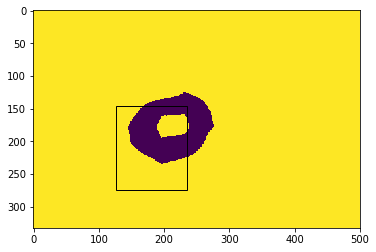

In [23]:
plt.imshow(thresh)
plt.gca().add_patch(plt.Rectangle((xmin, ymin), xmax-xmin,ymax-ymin, fill=False))

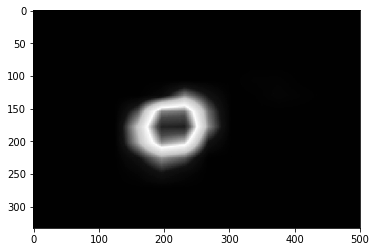

In [77]:
plt.imshow(gray, cmap='gray')

In [121]:
gray

array([[15, 15, 15, ..., 15, 15, 15],
       [15, 15, 15, ..., 15, 15, 15],
       [15, 15, 15, ..., 15, 15, 15],
       ..., 
       [15, 15, 15, ..., 15, 15, 15],
       [15, 15, 15, ..., 15, 15, 15],
       [15, 15, 15, ..., 15, 15, 15]], dtype=uint8)

In [97]:
np.median(gray)

15.0

In [122]:
mask = gray > int(np.median(gray))

In [128]:
gray.shape

(333, 500)

In [125]:
mask

array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ..., 
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]], dtype=bool)

In [137]:
x_cords, y_cords = np.where(gray>np.mean(gray))

In [138]:
x_cords, y_cords

(array([114, 114, 114, ..., 255, 255, 255], dtype=int64),
 array([228, 229, 230, ..., 201, 202, 203], dtype=int64))

In [139]:
xmin, ymin, xmax, ymax = np.min(x_cords), np.min(y_cords), np.max(x_cords), np.max(y_cords)

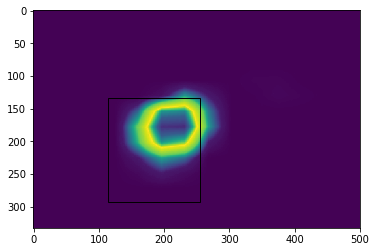

In [140]:
plt.imshow()
plt.gca().add_patch(plt.Rectangle((xmin, ymin), xmax-xmin, ymax-ymin, fill=False))

In [131]:
np.take(gray, np.vstack((x_cords, y_cords))).shape

(333, 2, 29547)

In [85]:
gray[mask].shape

(16491,)

In [86]:
obj = np.take(gray, mask)
obj.shape

(333, 500)

In [89]:
gray[:, mask]

IndexError: too many indices for array

In [94]:
gray.

AttributeError: 'numpy.ndarray' object has no attribute 'mode'

In [6]:
with open('./labels_bbox_only.pkl', 'rb') as labels:
    all_labels = pickle.load(labels)

In [7]:
with open('final_partition.pkl', 'rb') as part_file:
    final_parition = pickle.load(part_file)

In [7]:
def get_iou(boxA, boxB):
    
    try:
        # determine the (x, y)-coordinates of the intersection rectangle
        xA = max(boxA[0], boxB[0])
        yA = max(boxA[1], boxB[1])
        xB = min(boxA[2], boxB[2])
        yB = min(boxA[3], boxB[3])

        # compute the area of intersection rectangle
        interArea = (xB - xA + 1) * (yB - yA + 1)

        # compute the area of both the prediction and ground-truth
        # rectangles
        boxAArea = (boxA[2] - boxA[0] + 1) * (boxA[3] - boxA[1] + 1)
        boxBArea = (boxB[2] - boxB[0] + 1) * (boxB[3] - boxB[1] + 1)

        # compute the intersection over union by taking the intersection
        # area and dividing it by the sum of prediction + ground-truth
        # areas - the interesection area
        iou = interArea / float(boxAArea + boxBArea - interArea)

        # return the intersection over union value
        return iou
    except:
        return 0

In [9]:
img_path = './bbox_dataset/images/'
annot_path = './bbox_dataset/annotations/'
#layername = 'block5_conv3'
layername = 'add_16'
net = resnet
hmap_path = './heatmap_add_16.jpg'
img_cam = './image_cam_add_16.jpg'
save_path = './bbox_pics/resnet/'

In [10]:
IOUS = {}
count = 1
for each_img, bbox in all_labels.items():
    imgpath = img_path + each_img + '.jpg'
    gradcam(net, imgpath, layername)
    bestbox = bbox_gcam(hmap_path, img_cam, each_img, save_path)
    IOUS[each_img] = get_iou(bbox, bestbox)
    if len(IOUS) % 100 == 0:
        print("processed ", 100*count, "images")
        count = count + 1

D:\toolkits\Anaconda3\envs\DL\lib\site-packages\ipykernel_launcher.py:49: RuntimeWarning: invalid value encountered in true_divide


processed  100 images
processed  200 images
processed  300 images
processed  400 images
processed  500 images
processed  600 images
processed  700 images
processed  800 images
processed  900 images
processed  1000 images
processed  1100 images


KeyboardInterrupt: 

In [11]:
IOUS

{'2010_005426': 0.6257369343530912,
 '2007_006641': 0.3303056516724337,
 '2011_003844': 0.3440804277867841,
 '2008_006694': 0.7252844252648097,
 '2011_005708': 0.09451858057566873,
 '2009_002173': 0.3846817248459959,
 '2009_005142': 0.18686868686868688,
 '2010_000651': 0,
 '2010_000045': 0.685536849099268,
 '2008_007909': 0.990688,
 '2009_001549': 0.1744381593028589,
 '2008_008092': -0.7322531603960939,
 '2009_000327': 0.2685141065830721,
 '2009_000720': 0.025421133231240428,
 '2010_000009': 0.41646530894028305,
 '2008_007875': 0.002348560790491193,
 '007775': 0.6640843167282227,
 '2011_004898': 0.27305959035259075,
 '2012_001735': -1.6807151979565773,
 '2008_008170': 0.41662458337541664,
 '009898': 0.9899659059197515,
 '2011_001624': -1.1521691257432283,
 '2012_000072': 0.5108330555626779,
 '2011_006424': 0.14898336414048058,
 '2011_000673': -0.0829618320610687,
 '2009_001638': 0.9188587616349656,
 '2010_001687': 0.6697690601487409,
 '2009_004436': 0.516852914316786,
 '2008_006462': 0

In [12]:
final_parition['train']

['000002',
 '000007',
 '000012',
 '000015',
 '000016',
 '000018',
 '000020',
 '000024',
 '000026',
 '000027',
 '000028',
 '000029',
 '000031',
 '000036',
 '000037',
 '000040',
 '000046',
 '000049',
 '000053',
 '000054',
 '000056',
 '000057',
 '000062',
 '000064',
 '000065',
 '000067',
 '000068',
 '000071',
 '000074',
 '000075',
 '000079',
 '000087',
 '000088',
 '000092',
 '000098',
 '000099',
 '000100',
 '000106',
 '000109',
 '000113',
 '000114',
 '000115',
 '000117',
 '000118',
 '000119',
 '000120',
 '000122',
 '000123',
 '000130',
 '000132',
 '000134',
 '000135',
 '000141',
 '000142',
 '000143',
 '000146',
 '000148',
 '000158',
 '000165',
 '000167',
 '000172',
 '000174',
 '000175',
 '000180',
 '000183',
 '000186',
 '000189',
 '000195',
 '000197',
 '000198',
 '000199',
 '000207',
 '000209',
 '000213',
 '000214',
 '000215',
 '000216',
 '000219',
 '000221',
 '000228',
 '000236',
 '000242',
 '000243',
 '000244',
 '000246',
 '000253',
 '000255',
 '000256',
 '000262',
 '000267',
 '000270',

In [12]:
with open('IOUS_resnet.pkl', 'wb') as iousvgg:
    pickle.dump(IOUS, iousvgg)

In [13]:
keys = IOUS.values()

In [22]:
resnet_iou = np.mean(list(keys))

In [23]:
print("resnet mean iou", resnet_iou)

resnet mean iou 0.291884325557
